In [2]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # FFFFF

# Data loading
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

# Auxiliary functions
from torch.utils.tensorboard import SummaryWriter  # Used for Tensorboard logging
import os
import numpy as np
import matplotlib.pyplot as plt
from math import floor, ceil
import datetime



from dataset_semseg import SupermarketSemSeg

# Segmentación de imagen mediante arquitectura U-Net

In [3]:
PATH_ROOT = os.path.join('.')
# Ruta para datos:
PATH_DATA = os.path.join(PATH_ROOT, 'data')
# Ruta para modelos:
PATH_MODELS = os.path.join(PATH_ROOT, 'reports', 'models')
# Ruta para resultados:
PATH_RESULTS = os.path.join(PATH_ROOT, 'reports', 'results')
# Ruta para ejecuciones:
PATH_RUNS = os.path.join(PATH_ROOT, 'reports', 'runs')

In [4]:
# Para cada sesión creamos un directorio nuevo, a partir de la fecha y hora de su ejecución:
date = datetime.datetime.now()
test_name = str(date.year) + '_' + str(date.month) + '_' +  str(date.day) + '__' + str(date.hour) + '_' + str(date.minute)
print('Nombre del directorio de pruebas: {}'.format(test_name))
models_folder = os.path.join(PATH_MODELS, test_name)
try:
    os.makedirs(models_folder)
except:
    print(f'Folder {models_folder} already existed.')
results_folder = os.path.join(PATH_RESULTS, test_name)
try:
    os.makedirs(results_folder)
except:
    print(f'Folder {results_folder} already existed.')
runs_folder = os.path.join(PATH_RUNS, test_name)
try:
    os.makedirs(runs_folder)
except:
    print(f'Folder {runs_folder} already existed.')


Nombre del directorio de pruebas: 2025_11_19__13_10


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)   

cuda


## Definición del modelo

Como vamos a repetir la estructura de Convolución, Convolución, pooling, hacemos una clase para ello

In [6]:
class DoubleConv(nn.Module):
    """
    Conv3x3 -> ReLU -> Conv3x3 -> ReLU
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


In [7]:
class Down(nn.Module):
    """
    MaxPool2x2 -> DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x


In [8]:
class Up(nn.Module):
    """
    UpConv2x2 -> concat con skip -> DoubleConv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)  # in_channels = (up_out + skip)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([skip, x], dim=1)
        x = self.conv(x)
        return x


In [9]:
class OutConv(nn.Module):
    # Conv1x1 para la salida
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, num_classes, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [10]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=11, base_ch=64):
        super().__init__()

        # Encoder
        self.inc = DoubleConv(in_channels, base_ch)          # 3 -> 64
        self.down1 = Down(base_ch, base_ch * 2)              # 64 -> 128
        self.down2 = Down(base_ch * 2, base_ch * 4)          # 128 -> 256
        self.down3 = Down(base_ch * 4, base_ch * 8)          # 256 -> 512
        self.down4 = Down(base_ch * 8, base_ch * 16)         # 512 -> 1024

        # Decoder
        self.up1 = Up(base_ch * 16, base_ch * 8)             # 1024 -> 512
        self.up2 = Up(base_ch * 8, base_ch * 4)              # 512 -> 256
        self.up3 = Up(base_ch * 4, base_ch * 2)              # 256 -> 128
        self.up4 = Up(base_ch * 2, base_ch)                  # 128 -> 64

        # Capa final
        self.outc = OutConv(base_ch, num_classes)            # 64 -> num_clases

    def forward(self, x):
        x1 = self.inc(x)     # (B, 64, 144, 192)
        x2 = self.down1(x1)  # (B, 128, 72, 96)
        x3 = self.down2(x2)  # (B, 256, 36, 48)
        x4 = self.down3(x3)  # (B, 512, 18, 24)
        x5 = self.down4(x4)  # (B, 1024, 9, 12)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)  # (B, num_clases, 144, 192)
        return logits


## Carga de Datos

In [11]:
clase = "train"
root_images_train = f"./dataset_res_144_192_10classes/{clase}/images/"
root_masks_train = f"./dataset_res_144_192_10classes/{clase}/masks/"

clase = "test"
root_images_test = f"./dataset_res_144_192_10classes/{clase}/images/"
root_masks_test = f"./dataset_res_144_192_10classes/{clase}/masks/"

dataset_train = SupermarketSemSeg(images_dir=root_images_train, masks_dir=root_masks_train, include_filenames=True)
dataset_test = SupermarketSemSeg(images_dir=root_images_test, masks_dir=root_masks_test, include_filenames=True)

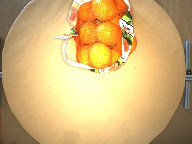

In [12]:
x = dataset_train.__getitem__(400)
mask = x["mask"]
dataset_train._read_image(p = x["image_path"])

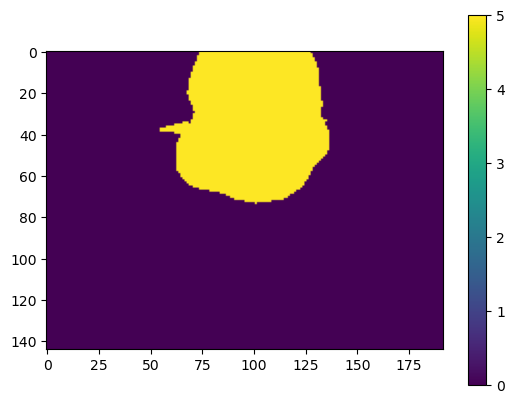

In [13]:
plt.imshow(mask.numpy())
plt.colorbar()
plt.show()

In [14]:
total_size = len(dataset_train)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(
    dataset_train, 
    [train_size, val_size], 
    generator=generator
)

batch_size = 2  # Tamaño de lotes
num_workers = 0  # Controla cuántos procesos cargan datos en paralelo (lo dejaremos a 0 para ahorrar recursos)

In [15]:
train_loader = DataLoader(
    dataset=train_dataset,      
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

val_loader = DataLoader(
    dataset=val_dataset,        
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

test_loader = DataLoader(
    dataset=dataset_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

In [16]:
def train_seg(model, train_loader, val_loader, criterion, optimizer, epochs, device):

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            imgs = batch["image"].to(device)      # (B, 3, H, W)
            masks = batch["mask"].long().to(device)  # (B, H, W)

            optimizer.zero_grad()

            outputs = model(imgs)                 # (B, 10, H, W)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}")

        # -------- VALIDACIÓN --------
        model.eval()
        running_val_loss = 0.0
        running_correct = 0
        running_total = 0

        with torch.no_grad():
            for batch in val_loader:
                imgs = batch["image"].to(device)
                masks = batch["mask"].long().to(device)

                outputs = model(imgs)
                loss = criterion(outputs, masks)
                running_val_loss += loss.item()

                preds = outputs.argmax(1)  # (B, H, W)
                running_correct += (preds == masks).sum().item()
                running_total += masks.numel()

        avg_val_loss = running_val_loss / len(val_loader)
        val_acc = running_correct / running_total

        val_losses.append(avg_val_loss)

        print(f"           Val Loss: {avg_val_loss:.4f} - Val Pixel Accuracy: {val_acc:.4f}")

    return train_losses, val_losses


In [17]:
def test_seg(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    with torch.no_grad():
        for batch in test_loader:
            imgs = batch["image"].to(device)
            masks = batch["mask"].long().to(device)

            outputs = model(imgs)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

            preds = outputs.argmax(1)
            running_correct += (preds == masks).sum().item()
            running_total += masks.numel()

    avg_loss = running_loss / len(test_loader)
    pixel_acc = running_correct / running_total

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Pixel Accuracy: {pixel_acc:.4f}")

    return avg_loss, pixel_acc


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    in_channels=3,
    num_classes=11,
    base_ch=64
).to(device)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses = train_seg(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=20,
    device=device
)

Epoch 1/20 - Train Loss: 0.7454
           Val Loss: 0.3505 - Val Pixel Accuracy: 0.8941
Epoch 2/20 - Train Loss: 0.3506
           Val Loss: 0.2578 - Val Pixel Accuracy: 0.9201
Epoch 3/20 - Train Loss: 0.2841
           Val Loss: 0.2249 - Val Pixel Accuracy: 0.9413
Epoch 4/20 - Train Loss: 0.2227
           Val Loss: 0.1771 - Val Pixel Accuracy: 0.9559
Epoch 5/20 - Train Loss: 0.1682
           Val Loss: 0.1521 - Val Pixel Accuracy: 0.9572
Epoch 6/20 - Train Loss: 0.1531
           Val Loss: 0.1730 - Val Pixel Accuracy: 0.9519
Epoch 7/20 - Train Loss: 0.1490
           Val Loss: 0.1348 - Val Pixel Accuracy: 0.9590
Epoch 8/20 - Train Loss: 0.1420
           Val Loss: 0.2007 - Val Pixel Accuracy: 0.9506
Epoch 9/20 - Train Loss: 0.1459
           Val Loss: 0.1271 - Val Pixel Accuracy: 0.9607
Epoch 10/20 - Train Loss: 0.1465
           Val Loss: 0.1318 - Val Pixel Accuracy: 0.9599
Epoch 11/20 - Train Loss: 0.1305
           Val Loss: 0.1221 - Val Pixel Accuracy: 0.9617
Epoch 12/20 - Train

In [20]:
test_seg(model, test_loader, criterion, device)

Test Loss: 1.6327
Test Pixel Accuracy: 0.5555


(1.6327209608499393, 0.5555237044214757)